In [66]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from google import genai
import os
from google.genai.types import GenerateContentConfig
import operator

In [67]:
#Creating the object of GEMINI Model 
load_dotenv()
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [68]:
class EvaluateSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description='Score out of 10', ge=0, le=10)



In [44]:
#TEST

# 1. Load the environment variables
loaded = load_dotenv()

# 2. Get the key
api_key = os.getenv("GOOGLE_API_KEY") # Make sure this name matches your .env file exactly

print(f"1. Did .env file load? -> {loaded}")
print(f"2. Is api_key variable found? -> {api_key is not None}")

if api_key:
    # Print only the first 4 characters for safety
    print(f"3. Key starts with: {api_key[:4]}...")
    print(f"4. Key length: {len(api_key)}")
else:
    print("3. RESULT: The code cannot read the variable. Check your .env file.")

1. Did .env file load? -> True
2. Is api_key variable found? -> True
3. Key starts with: AIza...
4. Key length: 39


In [69]:


if not api_key:
    raise ValueError("Error: GEMINI_API_KEY is missing from .env file.")

# 3. CRITICAL FIX: Initialize Client with the key here
# Do NOT rely on automatic detection if it is failing.
client = genai.Client(api_key=api_key)

#Coming from Pydantic to json
schema = EvaluateSchema.model_json_schema()

#parsing
config = GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=schema
)

# 4. Run the model
# Note: "gemini-2.5-flash" does not exist publicly yet.
# Use "gemini-1.5-flash" or "gemini-2.0-flash-exp"
try:
    response = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents="Evaluate this essay: The quick brown fox jumps over the lazy dog.",
        config=config
    )
    
    # 5. Validate and print
    result = EvaluateSchema.model_validate_json(response.text)
    print(f"Feedback: {result.feedback}")
    print(f"Score: {result.score}")

except Exception as e:
    print(f"An error occurred: {e}")

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


Feedback: The provided text is a single sentence, famously known as a pangram, which contains every letter of the alphabet. While it demonstrates correct grammar, subject-verb agreement, and descriptive language ('quick brown fox', 'lazy dog'), it does not meet the criteria of an 'essay.' An essay typically requires multiple paragraphs, an introduction, body paragraphs developing a central argument or idea, and a conclusion. This submission lacks any form of development, analysis, or structured argument, and is far too short to be considered an essay. It functions perfectly as a sentence but falls short when evaluated as a more substantial piece of writing.
Score: 2


In [70]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [49]:
essay = """The Dual Edges of Artificial Intelligence
Artificial Intelligence (AI) has evolved from a theoretical concept in science fiction into a tangible force reshaping the infrastructure of modern society. At its core, AI represents the capability of machines to emulate human cognition, utilizing machine learning and neural networks to process vast amounts of data. Today, its applications are ubiquitous, ranging from recommendation algorithms on streaming platforms to complex diagnostic tools in healthcare that can detect pathologies earlier than human practitioners.
The most significant recent leap has been in Generative AI, which allows systems not merely to analyze existing data but to create new content, code, and strategies. This capability promises to unlock unprecedented levels of productivity and creativity across industries. However, this rapid technological ascent brings critical ethical challenges. Issues surrounding data privacy, the potential for algorithmic bias, and the displacement of the workforce create a complex landscape that developers and policymakers must navigate carefully.
In conclusion, while AI holds the potential to solve some of humanity's most pressing problems, it is not a panacea. The future of artificial intelligence depends on a balanced approach—one that embraces innovation while rigorously enforcing ethical standards to ensure these powerful tools augment, rather than diminish, the human experience."""

In [83]:
def evaluate_language(state: UPSCState)->UPSCState:
    prompt = f'Evaluate the language quality of the following eaasy and provide the feedback and assign a score out of 10 \n {state["essay"]}'
    response = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents=prompt,
        config=config)
    
    result = EvaluateSchema.model_validate_json(response.text)
    return {'language_feedback': result.feedback, 'individual_scores': [result.score]}




def evaluate_analysis(state: UPSCState)->UPSCState:
    prompt = f'Evaluate the depth of the following eaasy and provide the feedback and assign a score out of 10 \n {state["essay"]}'
    response = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents=prompt,
        config=config)
    
    result = EvaluateSchema.model_validate_json(response.text)
    return {'analysis_feedback': result.feedback, 'individual_scores': [result.score]}



def evaluate_thought(state: UPSCState)->UPSCState:
    prompt = f'Evaluate the clarity of thought of the following eaasy and provide the feedback and assign a score out of 10 \n {state["essay"]}'
    response = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents=prompt,
        config=config)
    
    result = EvaluateSchema.model_validate_json(response.text)
    return {'clarity_feedback': result.feedback, 'individual_scores': [result.score]}


def final_evaluation(state: UPSCState)-> UPSCState:
    #summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback /n language feedback - {state["language_feedback"]} /n depth of analysis feedback - {state["analysis_feedback"]} /n and clarity of thought feedback - {state["clarity_feedback"]}.'
    overall_feedback = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents=prompt
    )
    overall_feedback = overall_feedback.text
    

    # avg calculator
    avg_score=sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}


In [84]:
graph = StateGraph(UPSCState)



graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)


# add edges

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)


workflow = graph.compile()




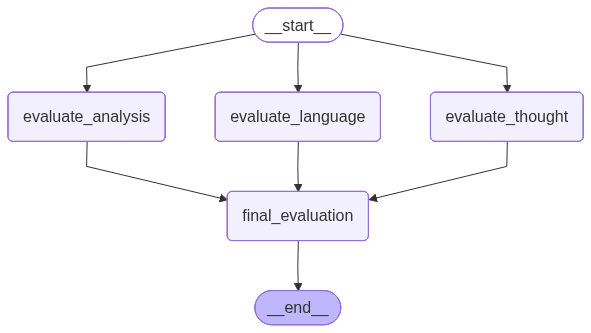

In [85]:
workflow

In [86]:
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

{'essay': "The Dual Edges of Artificial Intelligence\nArtificial Intelligence (AI) has evolved from a theoretical concept in science fiction into a tangible force reshaping the infrastructure of modern society. At its core, AI represents the capability of machines to emulate human cognition, utilizing machine learning and neural networks to process vast amounts of data. Today, its applications are ubiquitous, ranging from recommendation algorithms on streaming platforms to complex diagnostic tools in healthcare that can detect pathologies earlier than human practitioners.\nThe most significant recent leap has been in Generative AI, which allows systems not merely to analyze existing data but to create new content, code, and strategies. This capability promises to unlock unprecedented levels of productivity and creativity across industries. However, this rapid technological ascent brings critical ethical challenges. Issues surrounding data privacy, the potential for algorithmic bias, an